# Bag-of-Words Classifier Pipeline

In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import sklearn.neural_network

# Custom functions 
from utils import (
    print_gridsearch_results, 
    test_on_estimator, 
    plot_cv_train_test, 
    plot_cv_folds, 
    analysis_of_mistakes,
)

RANDOM_STATE = 123

In [2]:
# Plotting utils
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

## Data prep

In [3]:
data_dir = 'data_reviews'
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))

# Where to output predictions on the test_set
x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
output_dir = 'predictions'

print("Shape of data\n---------------")
print(f"x_train_df shape: {x_train_df.shape} ")
print(f"x_test_df shape: {x_test_df.shape} ")
print(f"y_train_df shape: {y_train_df.shape} ")

# Get the text as a list of strings
x_train_text = x_train_df['text'].values
x_test_text = x_test_df['text'].values
y_train = y_train_df['is_positive_sentiment'].values

Shape of data
---------------
x_train_df shape: (2400, 2) 
x_test_df shape: (600, 2) 
y_train_df shape: (2400, 1) 


## Dataset Exploration

In [4]:
num_train_samples = x_train_text.shape[0]
num_positive_train_samples = np.count_nonzero(y_train == 1)
fraction_positive_train = float(num_positive_train_samples) / float(num_train_samples)


print(f"Total number of training samples = {num_train_samples}")
print(f"Fraction positive training samples = {fraction_positive_train}")


Total number of training samples = 2400
Fraction positive training samples = 0.5


## Define a stable SKF CV-splitter and a TF-IDF Vectorizer

In [9]:
cv_splitter = sklearn.model_selection.StratifiedKFold(n_splits=5)

In [10]:
tf_vectorizer = TfidfVectorizer(stop_words='english')

# Static Parameters based on earlier grid_search 
tf_vectorizer.set_params(min_df = 1, ngram_range = (1,2))

# Set the tuple for the pipeline
tf_pipeline_tuple = ("tf", tf_vectorizer)


# Model 1: Random Forest

## Random Forest: Max Depth Hyperparameter Search

In [23]:
rf_classifier = RandomForestClassifier(random_state=RANDOM_STATE)
# Random Forest hyperparameter grid
rf_parameters = {
    "rf__max_depth": np.linspace(1, 15, 5).astype(int),
    "rf__min_samples_split": np.linspace(2, 40,4).astype(int),
    "rf__n_estimators": np.linspace(1,200,5).astype(int),
}
rf_pipeline_tuple = ('rf', rf_classifier)
print(rf_parameters)

{'rf__max_depth': array([ 1,  4,  8, 11, 15]), 'rf__min_samples_split': array([ 2, 14, 27, 40]), 'rf__n_estimators': array([  1,  50, 100, 150, 200])}


### Fit on the tfidf_vectorizer

In [24]:
tf_rf_pipeline = Pipeline([
    tf_pipeline_tuple,
    rf_pipeline_tuple,
 ])
tf_rf_full_grid = { 
#     **tf_parameters,
    **rf_parameters
}


tf_rf_grid_searcher = GridSearchCV(
    tf_rf_pipeline, 
    tf_rf_full_grid, 
    cv=cv_splitter, 
    n_jobs=4,  
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
tf_rf_grid_searcher.fit(x_train_text, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   30.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   57.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('rf',
                                        RandomForestClassifier(random_state=123))]),
             n_jobs=4,
             param_grid={'rf__max_depth': array([ 1,  4,  8, 11, 15]),
                         'rf__min_samples_split': array([ 2, 14, 27, 40]),
                         'rf__n_estimators': array([  1,  50, 100, 150, 200])},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [25]:
print_gridsearch_results(tf_rf_grid_searcher, list(tf_rf_full_grid.keys()))

Dataframe has shape: (100, 23)
Number of trials used in grid search:  100


,param_rf__max_depth,param_rf__min_samples_split,param_rf__n_estimators,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
93,15,27,150,0.853854,0.751250,0.431915,1
98,15,40,150,0.852604,0.750833,0.426151,2
88,15,14,150,0.857083,0.750000,0.483041,3
68,11,14,150,0.857292,0.749583,0.444598,4
83,15,2,150,0.876354,0.749583,0.524564,4
...,...,...,...,...,...,...,...
30,4,27,1,0.511563,0.520000,0.070415,93
10,1,27,1,0.505938,0.512083,0.074421,97
15,1,40,1,0.505938,0.512083,0.076149,97
5,1,14,1,0.505938,0.512083,0.064952,97


In [26]:
print_gridsearch_results(tf_rf_grid_searcher, list(tf_rf_full_grid.keys()))

Dataframe has shape: (100, 23)
Number of trials used in grid search:  100


,param_rf__max_depth,param_rf__min_samples_split,param_rf__n_estimators,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
93,15,27,150,0.853854,0.751250,0.431915,1
98,15,40,150,0.852604,0.750833,0.426151,2
88,15,14,150,0.857083,0.750000,0.483041,3
68,11,14,150,0.857292,0.749583,0.444598,4
83,15,2,150,0.876354,0.749583,0.524564,4
...,...,...,...,...,...,...,...
30,4,27,1,0.511563,0.520000,0.070415,93
10,1,27,1,0.505938,0.512083,0.074421,97
15,1,40,1,0.505938,0.512083,0.076149,97
5,1,14,1,0.505938,0.512083,0.064952,97


## RF: Gridsearch plots over various HP's

In [28]:
# Plotting the CV results for a gridsearch over one HP

cv_results = tf_rf_grid_searcher.cv_results_
# Two plots: One comparing train and test performance; one comparing all of the fold scores against one another 
# Plot one
param_1 = "rf__max_depth"
param_label_1 = "Max Depth of each tree"

param_2 = "rf__n_estimators"
param_label_2 = "Number of trees in forest frequency"

In [86]:
# Plot one: A look at a single CV
def plot_cv_train_test(cv_results, param_name, param_label, log10=False, log2=False):

    param_name = f'param_{param_name}'
    cv_results_temp = pd.DataFrame(cv_results).sort_values(param_name)
    param_values = cv_results_temp[param_name].values
    mean_test_score = cv_results_temp['mean_test_score'].values
    mean_train_score = cv_results_temp['mean_train_score'].values

    # Plot Grid search scores
    _, ax = plt.subplots(1, 1)

    x_values = param_values.astype(np.float64)
    average_test_x = []
    average_train_x = []
    print(param_values)
    for i, value in enumerate(param_values): 
        value_idx = np.where(param_values == value)
        average_train_x.append(np.mean(mean_train_score[value_idx]))
        average_test_x.append(np.mean(mean_test_score[value_idx]))
    
    if (log10):
        x_values = np.log10(x_values)
    elif (log2):
        x_values = np.log2(x_values)
    ax.plot(x_values, mean_test_score, 'or', label='test set')
    ax.plot(x_values, mean_train_score, 'ob', label='train set')
    ax.plot(x_values, average_test_x, '--or', label='average test score')
    ax.plot(x_values, average_train_x, '--ob', label='average train score')


    ax.set_title(f"{param_label} Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(param_label, fontsize=16)
    ax.set_ylabel('Balanced Accuracy', fontsize=16)
    ax.legend(loc="best", fontsize=15, bbox_to_anchor=(1, 1))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 150 150 150 150 150 150 150 150 150
 150 150 150 150 150 150 150 150 150 150 150 200 200 200 200 200 200 200
 200 200 200 200 200 200 200 200 200 200 200 200 200]


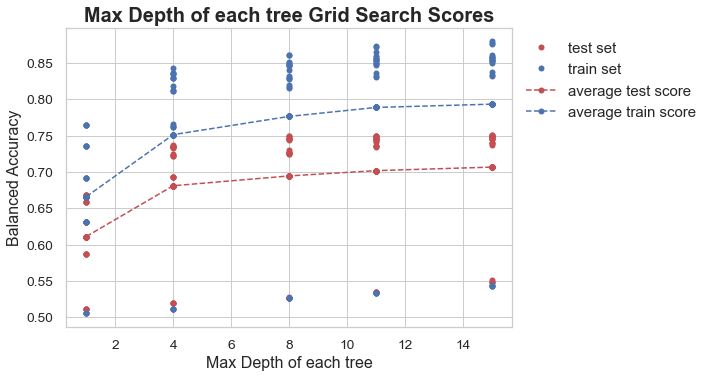

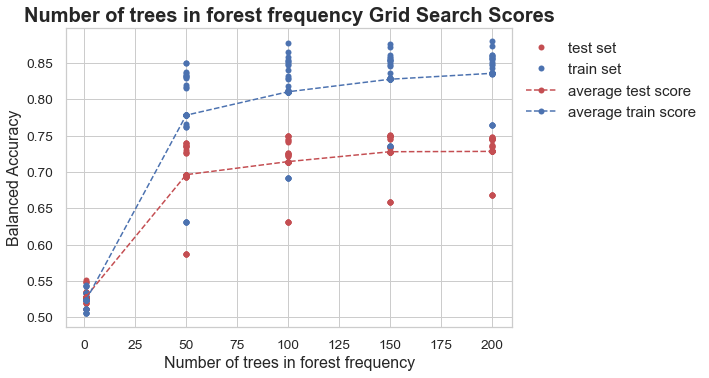

In [88]:
plot_cv_train_test(cv_results, param_1, param_label_1)
plot_cv_train_test(cv_results, param_2, param_label_2)

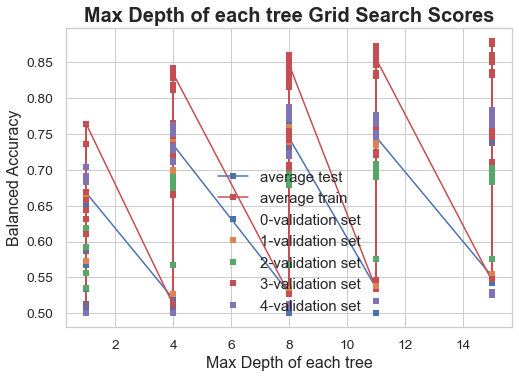

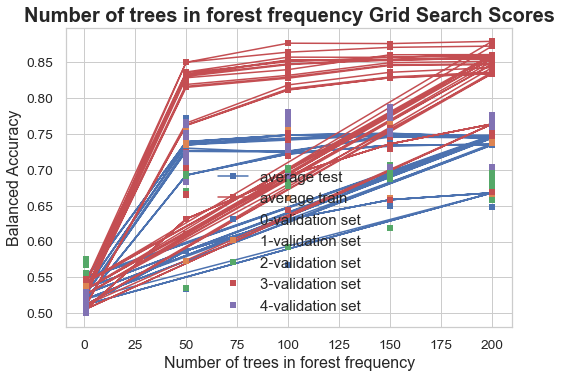

In [53]:
plot_cv_folds(cv_results, param_1, param_label_1, cv_splitter.n_splits)
plot_cv_folds(cv_results, param_2, param_label_2, cv_splitter.n_splits)

## Analysis of mistakes 

In [49]:
tf_rf_best_pipeline = tf_rf_grid_searcher.best_estimator_
analysis_of_mistakes(tf_rf_best_pipeline, x_train_df, y_train)

[[1133   67]
 [ 246  954]]
----- False Positives
Average Length of Sentences:    10.567164179104477
Breakdown of website names:     {'imdb': 0.417910447761194, 'amazon': 0.2835820895522388, 'yelp': 0.29850746268656714}
Percentage with negation words: 0.4626865671641791
...Examples
...Examples
I would not recommend this item to anyone.
If you are looking for a good quality Motorola Headset keep looking, this isn't it.
I really wanted the Plantronics 510 to be the right one, but it has too many issues for me.The good
Excellent starter wireless headset.
At first I thought I was grtting a good deal at $7.44, until I plugged it into my phone (V3c Razr).
Lasted one day and then blew up.
Were JERKS on the phone.
I have had this phone for over a year now, and I will tell you, its not that great.
I am not impressed with this and i would not recommend this item to anyone.
You also cannot take pictures with it in the case because the lense is covered.


----- False Negatives
Average Length of Sen

## Generate predictions using best Random Forest and Count Vectorizer

In [18]:
# count_rf_filename = os.path.join(output_dir, 'bow_count_rf_yproba1_test.txt')
# test_on_estimator(count_rf_grid_searcher.best_estimator_, x_test_text, count_rf_filename)
tf_rf_filename = os.path.join(output_dir, 'bow_tf_rf_yproba1_test.txt')
test_on_estimator(tf_rf_grid_searcher.best_estimator_, x_test_text, tf_rf_filename)


## L1-Logistic Regression: Hyperparameter Search

In [41]:
lasso = sklearn.linear_model.LogisticRegression(penalty='l1', solver='saga', random_state=RANDOM_STATE)
# logit_lasso hyperparameter grid
lasso_parameters = {
     'lasso__C': np.logspace(-3, 3, 7),
     'lasso__max_iter': [20, 40, 60], # sneaky way to do "early stopping" 
}
lasso_pipeline_tuple = ('lasso', lasso)


In [47]:
tf_lasso_pipeline = Pipeline([
    tf_pipeline_tuple,
#     count_pipeline_tuple,
    lasso_pipeline_tuple,
 ])
tf_lasso_full_grid = { 
#     **count_parameters,
    **lasso_parameters
}


tf_lasso_grid_searcher = GridSearchCV(
    tf_lasso_pipeline, 
    tf_lasso_full_grid, 
    cv=cv_splitter, 
    n_jobs=3, 
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
tf_lasso_grid_searcher.fit(x_train_text, y_train)

Fitting 7 folds for each of 21 candidates, totalling 147 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  46 tasks      | elapsed:    1.9s
[Parallel(n_jobs=3)]: Done 147 out of 147 | elapsed:  1.5min finished
/Users/dylanphelan/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('lasso',
                                        LogisticRegression(penalty='l1',
                                                           random_state=123,
                                                           solver='saga'))]),
             n_jobs=3,
             param_grid={'lasso__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'lasso__max_iter': [20, 40, 60]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [48]:
print_gridsearch_results(tf_lasso_grid_searcher, list(tf_lasso_full_grid.keys()))

Dataframe has shape: (21, 26)
Number of trials used in grid search:  21


,param_lasso__C,param_lasso__max_iter,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
15,100,20,0.996736,0.805352,2.687669,1
18,1000,20,0.996736,0.805347,3.123508,2
19,1000,40,0.996736,0.804924,6.239316,3
12,10,20,0.994861,0.800764,0.702922,4
20,1000,60,0.997083,0.800332,9.199638,5
16,100,40,0.996736,0.799513,4.679206,6
14,10,60,0.995694,0.797852,1.312538,7
13,10,40,0.995486,0.797437,1.023129,8
17,100,60,0.996736,0.795759,6.014653,9
9,1,20,0.768543,0.748732,0.118917,10


In [44]:
print_gridsearch_results(tf_lasso_grid_searcher, list(tf_lasso_full_grid.keys()))

Dataframe has shape: (21, 26)
Number of trials used in grid search:  21


,param_lasso__C,param_lasso__max_iter,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
15,100,20,0.996736,0.805352,2.925823,1
18,1000,20,0.996736,0.805347,3.055707,2
19,1000,40,0.996736,0.804924,6.335847,3
12,10,20,0.994861,0.800764,0.729335,4
20,1000,60,0.997083,0.800332,9.195016,5
16,100,40,0.996736,0.799513,5.043728,6
14,10,60,0.995694,0.797852,1.398825,7
13,10,40,0.995486,0.797437,1.093864,8
17,100,60,0.996736,0.795759,6.167144,9
9,1,20,0.768543,0.748732,0.087844,10


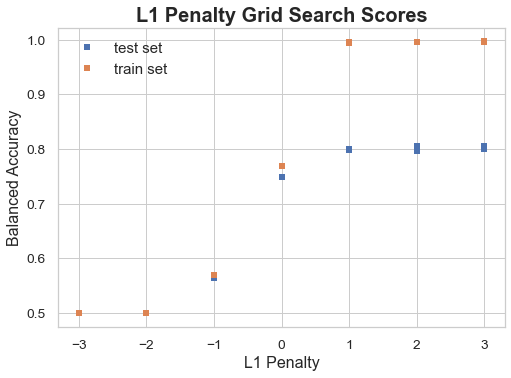

In [19]:
# Plotting the CV results for a gridsearch over one feature

cv_results = tf_lasso_grid_searcher.cv_results_
# Two plots: One comparing train and test performance; one comparing all of the fold scores against one another 
# Plot one
param = list(lasso_parameters.keys())[0]
param_label = "L1 Penalty"

plot_cv_train_test(cv_results, param, param_label, log10=True)

In [20]:
tf_lasso_grid_searcher.best_params_

{'lasso__C': 100.0, 'lasso__max_iter': 20}

## L1-Logistic Regression: Generate Predictions

In [25]:
lasso_filename = os.path.join(output_dir, 'bow_count_lasso_yproba1_test.txt')
test_on_estimator(count_lasso_grid_searcher.best_estimator_, x_test_text, lasso_filename)

# Model 3: Gradient Boosted Trees

## Gradient Boosted Tree: Hyperparameter search

**NOTE** Only re-run when necessary. The total run-time for rebuilding these classifiers is roughly 15-30 minutes.

In [29]:
gbtree_classifier = GradientBoostingClassifier(n_estimators=100, max_depth=5, min_samples_leaf=1, random_state=RANDOM_STATE)
# GradientBoosting-Tree hyperparameter grid
gbtree_parameters = {
    "gbtree__n_estimators": [100, 200, 300],
    "gbtree__max_depth": [5, 10, 20],
    "gbtree__min_samples_leaf": [1, 3, 5],
}
gbtree_pipeline_tuple = ('gbtree', gbtree_classifier)


### Fit on the tfidf_vectorizer

In [31]:
tf_gbtree_pipeline = Pipeline([
    tf_pipeline_tuple,
    gbtree_pipeline_tuple,
 ])
tf_gbtree_full_grid = { 
#     **tf_parameters,
    **gbtree_parameters
}


tf_gbtree_grid_searcher = GridSearchCV(
    tf_gbtree_pipeline, 
    tf_gbtree_full_grid, 
    cv=cv_splitter, 
    n_jobs=3, 
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
tf_gbtree_grid_searcher.fit(x_train_text, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   10.0s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed:  2.7min
[Parallel(n_jobs=3)]: Done 506 tasks      | elapsed:  6.4min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 11.6min
[Parallel(n_jobs=3)]: Done 1080 out of 1080 | elapsed: 20.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('gbtree',
                                        GradientBoostingClassifier(max_depth=5,
                                                                   random_state=123))]),
             n_jobs=3,
             param_grid={'gbtree__max_depth': [5, 10, 20],
                         'gbtree__min_samples_leaf': [1, 3, 5],
                         'gbtree__n_estimators': [100, 200, 300],
                         'tf__max_df': (0.05, 0.5), 'tf__min_df': array([1, 2]),
                         'tf__ngram_range': [(1, 1), (1, 2)]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [32]:
print_gridsearch_results(tf_gbtree_grid_searcher, list(tf_gbtree_full_grid.keys()))

Dataframe has shape: (216, 26)
Number of trials used in grid search:  216


,param_tf__min_df,param_tf__max_df,param_tf__ngram_range,param_gbtree__n_estimators,param_gbtree__max_depth,param_gbtree__min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
20,1,0.5,"(1, 1)",300,5,1,0.941979,0.776667,2.447076,1
12,1,0.5,"(1, 1)",200,5,1,0.923750,0.771667,1.560614,2
92,1,0.5,"(1, 1)",300,10,1,0.996146,0.770833,4.124050,3
22,2,0.5,"(1, 1)",300,5,1,0.947604,0.769583,1.807707,4
84,1,0.5,"(1, 1)",200,10,1,0.995937,0.769583,2.854647,5
...,...,...,...,...,...,...,...,...,...,...
27,2,0.05,"(1, 2)",100,5,3,0.819583,0.683333,0.581437,212
209,1,0.05,"(1, 2)",300,20,5,0.940521,0.683333,11.528023,212
48,1,0.05,"(1, 1)",100,5,5,0.797708,0.680833,0.613226,214
211,2,0.05,"(1, 2)",300,20,5,0.940417,0.680417,4.091111,215


In [34]:
tf_gbtree_grid_searcher.best_params_

{'gbtree__max_depth': 5,
 'gbtree__min_samples_leaf': 1,
 'gbtree__n_estimators': 300,
 'tf__max_df': 0.5,
 'tf__min_df': 1,
 'tf__ngram_range': (1, 1)}

## GBTree: Generate Predictions

In [37]:
gbtree_filename = os.path.join(output_dir, 'bow_tf_gbtree_yproba1_test.txt')
test_on_estimator(tf_gbtree_grid_searcher.best_estimator_, x_test_text, gbtree_filename)

In [81]:
# Plotting the CV results for a gridsearch over one feature
cv_results = tf_gbtree_grid_searcher.cv_results_

param = list(gbtree_parameters.keys())[0]
param_label = "Number of esitmators"

plot_cv_train_test(cv_results, param, param_label, log2=True)

NameError: name 'tf_gbtree_grid_searcher' is not defined

# Model 4: MLP Classifier

## MLP Classifier: Hyperparameter Search

In [8]:
mlp = sklearn.neural_network.MLPClassifier(solver='lbfgs', random_state=RANDOM_STATE)
mlp_parameters = {
    'mlp__hidden_layer_sizes': [16, 32, 64],
    'mlp__alpha': [0.0001,0.01,1, 10],
    'mlp__max_iter': [50, 100, 200, 500], # sneaky way to do "early stopping" 
}
mlp_pipeline_tuple = ('mlp', mlp)

In [9]:
tf_mlp_pipeline = Pipeline([
    tf_pipeline_tuple,
    mlp_pipeline_tuple,
 ])
tf_mlp_full_grid = { 
#     **tf_parameters,
    **mlp_parameters
}


tf_mlp_grid_searcher = GridSearchCV(
    tf_mlp_pipeline, 
    tf_mlp_full_grid, 
    cv=cv_splitter, 
    n_jobs=3, 
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
tf_mlp_grid_searcher.fit(x_train_text, y_train)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   38.6s
[Parallel(n_jobs=3)]: Done  96 out of  96 | elapsed:  4.1min finished
/Users/moose/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('mlp',
                                        MLPClassifier(random_state=123,
                                                      solver='lbfgs'))]),
             n_jobs=3,
             param_grid={'mlp__alpha': [0.0001, 0.01, 1, 10],
                         'mlp__hidden_layer_sizes': [16, 32, 64],
                         'mlp__max_iter': [50, 100, 200, 500]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [10]:
print_gridsearch_results(tf_mlp_grid_searcher, list(tf_mlp_full_grid.keys()))

Dataframe has shape: (48, 17)
Number of trials used in grid search:  48


,param_mlp__hidden_layer_sizes,param_mlp__alpha,param_mlp__max_iter,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
47,64,10,500,0.994167,0.742083,12.910476,1
45,64,10,100,0.994167,0.742083,15.025930,1
44,64,10,50,0.994167,0.742083,11.285674,1
46,64,10,200,0.994167,0.742083,15.725673,1
43,32,10,500,0.994167,0.741667,7.313832,5
42,32,10,200,0.994167,0.741667,6.289522,5
41,32,10,100,0.994167,0.741667,6.484619,5
40,32,10,50,0.994167,0.741667,7.196775,5
39,16,10,500,0.994167,0.741667,3.370050,5
38,16,10,200,0.994167,0.741667,2.938495,5


In [11]:
def plot_cv_train_test(cv_results, param_name, param_label, log10=False, log2=False):
    param_values = cv_results[f'param_{param_name}']
    mean_test_score = cv_results['mean_test_score']
    mean_train_score = cv_results['mean_train_score']

    # Plot Grid search scores
    _, ax = plt.subplots(1, 1)

    x_values = param_values.data.astype(np.float64)
    if (log10):
        x_values = np.log10(x_values)
    elif (log2):
        x_values = np.log2(x_values)
    ax.plot(x_values, mean_test_score, 's', label='test set')
    ax.plot(x_values, mean_train_score, 's', label='train set')

    ax.set_title(f"{param_label} Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(param_label, fontsize=16)
    ax.set_ylabel('Balanced Accuracy', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

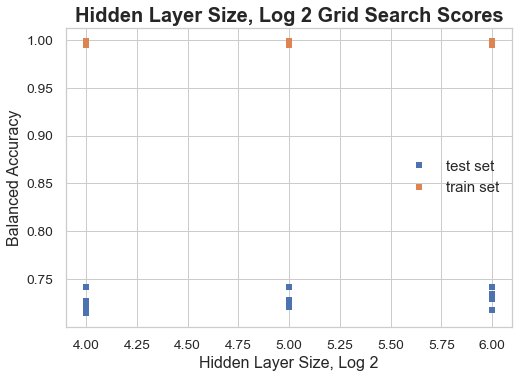

In [12]:
# Plotting the CV results for a gridsearch over one feature
cv_results = tf_mlp_grid_searcher.cv_results_

param = list(mlp_parameters.keys())[0]
param_label = "Hidden Layer Size, Log 2"

plot_cv_train_test(cv_results, param, param_label, log2=True)

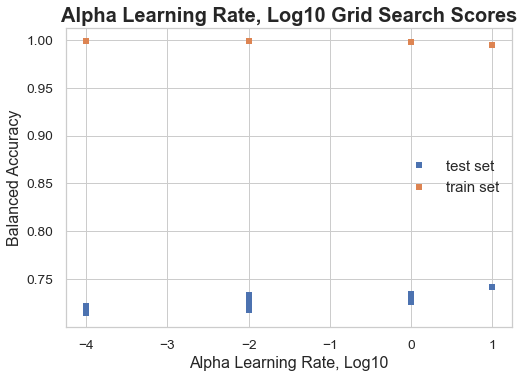

In [13]:
param = list(mlp_parameters.keys())[1]
param_label = "Alpha Learning Rate, Log10"

plot_cv_train_test(cv_results, param, param_label, log10=True)

In [14]:
tf_mlp_best_pipeline = tf_mlp_grid_searcher.best_estimator_
analysis_of_mistakes(tf_mlp_best_pipeline, x_train_df, y_train)

[[1193    7]
 [   8 1192]]
----- False Positives
Average Length of Sentences:    5.571428571428571
Breakdown of website names:     {'imdb': 0.5714285714285714, 'amazon': 0.14285714285714285, 'yelp': 0.2857142857142857}
Percentage with negation words: 0.7142857142857143
...Examples
Not good enough for the price.
Graphics is far from the best part of the game.  
It is not good.  
Why was this film made?  
Nothing at all to recommend.  
It was not good.
Would not recommend to others.


----- False Negatives
Average Length of Sentences:    5.75
Breakdown of website names:     {'imdb': 0.75, 'amazon': 0.125, 'yelp': 0.125}
Percentage with negation words: 0.5
...Examples
Would recommend this item.
GO AND SEE IT!  
Predictable, but not a bad watch.  
The last 15 minutes of movie are also not bad as well.  
Waste your money on this game.  
The soundtrack wasn't terrible, either.  
I don't think you will be disappointed.  
Will be back again!


----- True Positives
Average Length of Sentences: 

In [87]:
mlp_filename = os.path.join(output_dir, 'bow_tf_mlp_yproba1_test.txt')
test_on_estimator(tf_mlp_grid_searcher.best_estimator_, x_test_text, mlp_filename)

# Archive: Things We May Need 



In [39]:
# np.argwhere(count_rf_grid_searcher.cv_results_["rank_test_score"] == 1)
# count_rf_grid_searcher.cv_results_["mean_train_score"][29]


## Construction of two vectorizers - counts and tfidf


In [8]:
# count_vectorizer = CountVectorizer(stop_words='english')
# # #  Parameters for grid search
# # count_parameters = {
# #     'count__min_df': np.arange(1, 3),
# #     'count__max_df': (0.05, 0.5),
# #     'count__ngram_range': [(1, 1), (1, 2)],
# # }

# # Static Parameters based on earlier grid_search 
# count_vectorizer.set_params(min_df = 1, ngram_range = (1,2))


# # Set the tuple for the pipeline
# count_pipeline_tuple = ("count", count_vectorizer)


In [40]:
# random_forest_grid_searcher.fit(x_train_text_count, y_train)

In [41]:
# random_forest_grid_search_results_df = pd.DataFrame(random_forest_grid_searcher.cv_results_).copy()
# n_trials_grid_search = random_forest_grid_search_results_df.shape[0]

In [42]:
# param_keys = ['param_n_estimators', 'param_max_depth']

# # Rearrange row order so it is easy to skim
# random_forest_grid_search_results_df.sort_values(param_keys, inplace=True)
# random_forest_grid_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score']]

### Fit on TFIDF

In [43]:
# random_forest_grid_searcher.fit(x_train_text_tf, y_train)

In [44]:
# random_forest_grid_search_results_df = pd.DataFrame(random_forest_grid_searcher.cv_results_).copy()
# n_trials_grid_search = random_forest_grid_search_results_df.shape[0]

In [45]:
# param_keys = ['param_n_estimators', 'param_max_depth']

# Rearrange row order so it is easy to skim
# random_forest_grid_search_results_df.sort_values(param_keys, inplace=True)
# random_forest_grid_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score']]

In [56]:
# best_random_forest = random_forest_classifier.set_params(**random_forest_grid_searcher.best_params_)
# best_random_forest.fit(x_train_text_count, y_train)

In [47]:
# # Gradient Boosted Tree classifier with default values
# gbtree_classifier = GradientBoostingClassifier(n_estimators=100, max_depth=5, min_samples_leaf=1, random_state=100)

In [48]:
# # Gradient Boosted Tree hyperparameter grid
# gbtree_parameter_grid = dict(
#     n_estimators = [20, 50, 100],
#     max_depth = [5, 10],
#     #min_samples_leaf = [1, 3, 5],
#     #random_state=[101, 202],  # try two possible seeds to initialize parameters
#     random_state=[100],
#     )

In [49]:
# gbtree_grid_searcher = sklearn.model_selection.GridSearchCV(
#     gbtree_classifier,
#     gbtree_parameter_grid,
#     scoring='balanced_accuracy',
#     cv=cv_splitter,
#     return_train_score=True,
#     refit=False)

In [50]:
# gbtree_grid_searcher.fit(x_train_text_count, y_train)

In [51]:
# gbtree_grid_search_results_df = pd.DataFrame(gbtree_grid_searcher.cv_results_).copy()
# n_trials_grid_search = gbtree_grid_search_results_df.shape[0]

In [52]:
# param_keys = ['param_n_estimators', 'param_max_depth']

# # Rearrange row order so it is easy to skim
# gbtree_grid_search_results_df.sort_values(param_keys, inplace=True)

In [53]:
# gbtree_grid_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score']]

In [54]:
# best_gbtree = gbtree_classifier.set_params(**gbtree_grid_searcher.best_params_)
# best_gbtree.fit(x_train_text_count, y_train)

In [63]:
# best_gbtree_yhat_test = best_gbtree.predict(x_test_text_count)
# with open('bow_gbtree_countvectorizer_test_preds.txt', 'w') as f:
#     for pred in best_gbtree_yhat_test:
#         f.write(str(pred) + '\n')

In [64]:
# lasso = sklearn.linear_model.LogisticRegression(
#     penalty='l1', solver='saga', random_state=101)

In [65]:
# lasso_hyperparameter_grid_by_name = dict(
#     C=np.logspace(-4, 4, 9),
#     max_iter=[20, 40], # sneaky way to do "early stopping" 
#                        # we'll take either iter 20 or iter 40 in training process, by best valid performance
#     )

In [66]:
# lasso_searcher = sklearn.model_selection.GridSearchCV(
#     lasso,
#     lasso_hyperparameter_grid_by_name,
#     scoring='balanced_accuracy',
#     cv=cv_splitter,
#     return_train_score=True,
#     refit=False)

In [67]:
# lasso_searcher.fit(x_train_text_count, y_train)

In [68]:
# lasso_search_results_df = pd.DataFrame(lasso_searcher.cv_results_).copy()

In [69]:
# param_keys = ['param_C', 'param_max_iter']

# # Rearrange row order so it is easy to skim
# lasso_search_results_df.sort_values(param_keys, inplace=True)

In [70]:
# lasso_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score']]

In [71]:
# best_lasso = lasso.set_params(**lasso_searcher.best_params_)
# best_lasso.fit(x_train_text_count, y_train)

In [72]:
# best_lasso_yhat_test = best_lasso.predict_proba(x_test_text_count)[:,1]
# np.savetxt('yproba1_test.txt', best_lasso_yhat_test)

### RF: Fit on CountVector

In [40]:
count_rf_pipeline = Pipeline([
    count_pipeline_tuple,
    rf_pipeline_tuple,
 ])
count_rf_full_grid = { 
#     **count_parameters,
    **rf_parameters
}


count_rf_grid_searcher = GridSearchCV(
    count_rf_pipeline, 
    count_rf_full_grid, 
    cv=cv_splitter, 
    n_jobs=3, 
    verbose=3,
    return_train_score=True,
    scoring='balanced_accuracy'
)
count_rf_grid_searcher.fit(x_train_text, y_train)

Fitting 7 folds for each of 25 candidates, totalling 175 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:   14.3s


KeyboardInterrupt: 

In [15]:
print_gridsearch_results(count_rf_grid_searcher, list(count_rf_full_grid.keys()))

Dataframe has shape: (50, 25)
Number of trials used in grid search:  50


,param_rf__max_depth,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
10,102.837,0.918541,0.775046,0.934253,1
6,62.102,0.907567,0.773368,0.666190,2
8,82.4694,0.915276,0.773365,0.792648,3
4,41.7347,0.898679,0.773363,0.617309,4
9,92.6531,0.916874,0.771714,0.856381,5
5,51.9184,0.902707,0.771692,0.668766,6
11,113.02,0.922429,0.769212,0.978202,7
7,72.2857,0.911109,0.768758,0.728714,8
49,500,0.997153,0.768744,1.807710,9
48,489.816,0.997153,0.767493,1.821891,10


In [ ]:
cv_results = count_rf_grid_searcher.cv_results_
# Two plots: One comparing train and test performance; one comparing all of the fold scores against one another 
# Plot one
param = list(rf_parameters.keys())[0]
param_label = "Max Depth of trees"

plot_cv_single_param(cv_results, param, param_label)


In [17]:
count_rf_grid_searcher.best_params_

{'rf__max_depth': 102.83673469387756}